# Gaussian Mixture Models
Mathematical Intuition and Implementation in Python

***
by: Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

### 1. Mathematical Intuition of EM algorithm for GMM

After setting manually the number of $K$ clusters to which we want to assign our $n$ observations of dimension $d$, we try to find the paramater of the K Gaussian distributions that achieves the best separation.

Each mixture component $k = 1, ..., K$ is a cluster $c_{k}$ specified by $\theta_{k} = \{ p_{k}, \mu_{k}, \Sigma_{k}\}$, where
1. $p_{k}$ represents the class weight (float) and $1 = \sum_{k = 1}^{K}p_{k}$,
2. $\mu_{k}$ is the mean vector of shape $(1, d)$, and
3. $\Sigma_{k}$ is the covariance matrix of shape $(d, d)$.

Also, we can write the probability density function of each Gaussian multivariate as

$$f_{k}(x_{i}) = \frac{1}{(2\pi)^{\frac{d}{2}} \det (\Sigma_{k})^{\frac{1}{2}}} \exp \left( -\frac{1}{2}(x_{i} - \mu_{k})^{T} \left(\Sigma_{k}\right)^{-1} (x_{i} - \mu_{k})\right)$$

**Maximization of Likelihood (difficult):**

The probability density function (single observation) of a mixture of k components is the product of the pdf of each component multiplied with its weight.

$$f(x) = \sum_{k = 1}^{K} p_{k} \times f_{k}(x)$$

Based on this, we can write the Likelihood of the whole sample (of size $n$) as the product of all pdfs (iid assumption).

$$L(X) = \prod_{i=1}^{n}f(x_i)$$

Maximizing this expression is *very difficult* due to $\text{nbr_unknown_param} = 3 \times K$ >> 0. To avoid this, we can use the **EM algorithm**.

**Expectation-Maximization Algorithm (EM)**

**1. Initialization:** In the lecture, it was proposed to run a kMeans algorithm (with K clusters) that performs an initial assignment of each observation $x_{i}$ to a cluster $z_{k}$. Based on this initial assignment, we find the three parameters of each of our mixture components as follows:

$$\hat{p}_{k}^{0} = \frac{1}{n}\sum_{i = 1}^{n}\mathbb{1}_{z_{i} = k}$$

$$\hat{\mu}_{k}^{0} = \frac{1}{n \times \hat{p}_{k}^{0}}\sum_{i = 1}^{n}\mathbb{1}_{z_{i} = k} x_{i}$$

$$\hat{\Sigma}_{k}^{0} = \frac{1}{n \times \hat{p}_{k}^{0}}\sum_{i = 1}^{n}\mathbb{1}_{z_{i} = k}(x_{i} - \hat{\mu}_{k}^{0})^{T} (x_{i} - \hat{\mu}_{k}^{0})$$

Thus, we find $\hat\theta_{k}^{0} = \{ \hat p_{k}^{0}, \hat\mu_{k}^{0}, \hat\sigma_{k}^{0}\}$ and we have fully described each cluster based on the currently predicted labels.

**2. Repeat E- and M-Step until convergence** (explanation below)

**2.1 Expectation Step (E-Step):** Based on our current best knowledge of the paramaters $\theta_{k}$ of each cluster, we compute for each observation $x_{i}$ the probability of belonging to each cluster $c_{k}$, namely the conditional probability matrix.

$$P_{\theta_{t}}(Z = k | X = x_{i}) = \frac{\hat{p}_{k}^{t} \times f_{k, t}(x_{i})}{\sum_{k = 1}^{k}\hat{p}_{k}^{t} \times f_{k, t}(x_{i})}$$

where $f_{k, t}(x_{i})$ denotes the probability density function of the respective Gaussian multivariate.

Note that $P_{\theta_{t}}(Z = k | X = x_{i})$ represents the column k of the conditional probability matrix as it only provides the probabilities that each observation $x_{i}$ belongs to the single cluster $c_{k}$. By combining all columns in a matrix, we retrieve the conditional probability matrix.

**2.2 Maximization Step (M-Step):** Based on our current best knowledge of which cluster each observation belongs to, we update the parameters $\theta_{k}$ of each cluster. The updates are computed as follows:

$$\hat{p}_{k}^{t+1} = \frac{1}{n}\sum_{i = 1}^{n}P_{\theta_{t}}(Z = k | X = x_{i})$$

$$\hat{\mu}_{k}^{t+1} = \frac{1}{n \times \hat{p}_{k}^{t+1}}\sum_{i = 1}^{n}x_{i}P_{\theta_{t}}(Z = k | X = x_{i})$$

$$\hat{\Sigma}_{k}^{t+1} = \frac{1}{n \times \hat{p}_{k}^{t+1}}\sum_{i = 1}^{n}P_{\theta_{t}}(Z = k | X = x_{i})(x_{i} - \hat{\mu}_{k}^{t+1})^{T} (x_{i} - \hat{\mu}_{k}^{t+1})$$

### 2. Implementation in Python (Multivariate GMM)

First, some basic imports.

In [1]:
# data handling
import pandas as pd

# calculations
import numpy as np
import math
from scipy.stats import mode
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

# plotting
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.patches import Ellipse
import seaborn as sns

In [2]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Now, let us build our GMM using the previously described EM algorithm. To help the algorithm converge faster, we will initialise each mixture component using the kMeans solution.

In [4]:
class my_GMM():
    
    def __init__(self, k, max_iter = 100, m = 10):
        '''
        Parameters:
        k: integer
            number of components
        max_iter: integer
            stopping criterion 1 - maximum number of iterations
        m: integer
            stopping criterion 2 - assume convergence if no change within the last m iterations
        
        Attributes:
        
        p_: (k,) np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: (k, d, d) np.array
            array cointaining covariance matrix where d donates the number of features in our data X
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        z_: (n,) np.array
            labels for data points
        '''
        self.k = k
        self.max_iter = int(max_iter)
        self.m = int(m)
        self.p_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.z_ = None
        
    def fit(self, X):
        """ Find the parameters
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        self.n, self.d = X.shape
        self.no_change = []
        self.initialise_with_kMeans(X)
        self.cond_prob_ = self.compute_condition_prob_matrix(X)
        
        for iteration in range(self.max_iter):
            # expectation step: update conditional probability matrix
            cond_prob_new = self.compute_condition_prob_matrix(X)
            
            # check stopping criterion 2 (assume convergence if 100% agreement in assigned labels m times in a row)
            z_new = self.predict(X)
            if np.mean(z_new == self.z_) == 1:
                self.no_change.append(1)
                if sum(self.no_change[-self.m:]) == self.m:
                    print(f"GMM of complexity {self.k} converged after iteration {iteration}")
                    break
            else:
                self.no_change.append(0)
            
            self.cond_prob_ = cond_prob_new
            self.z_ = self.predict(X)
            
            # maximization step: update parameters of each component
            self.p_ = self.cond_prob_.mean(axis = 0)
            for i in range(self.k):
                k_probs = self.cond_prob_[:, [i]]
                sum_probs = k_probs.sum()
                self.mu_[i] = (X * k_probs).sum(axis = 0) / sum_probs
                self.Sigma_[i] = np.cov(X.T, aweights=(k_probs/sum_probs).flatten(), bias = True)
        
        # check stopping criterion 1 (maximum number of iterations)
        if iteration == self.max_iter - 1:
            print(f"GMM of complexity {self.k} breaked after reaching maximum iteration ({self.max_iter})")
                
                
    def initialise_with_kMeans(self, X):
        # we initialise our clusters with the kMeans algorithm (see explanations above under "Math Intuition")
        kmeans = KMeans(n_clusters = self.k).fit(X)
        self.z_ = kmeans.labels_
        classes, counts = np.unique(self.z_, return_counts = True)
        # initialise weights (proportion of components)
        self.p_ = np.array([counts[c] / sum(counts) for c in classes])
        # initialise averages and covariance matrices
        means = np.zeros((self.k, self.d))
        covs = np.zeros((self.k, self.d, self.d))
        for idx, c in enumerate(classes):
            rows = np.where(self.z_ == c)
            means[idx] = [X[rows, col].mean() for col in range(self.d)]
            covs[idx] = np.cov(X[rows,][0].T, bias = True)
        self.mu_ = means
        self.Sigma_ = covs
        
        
    def compute_condition_prob_matrix(self, X):
        '''Compute the conditional probability matrix 
        shape: (n, K)
        '''
        likelihood = np.zeros((self.n, self.k))
        for i in range(self.k):
            f = multivariate_normal(mean = self.mu_[i],
                                    cov = self.Sigma_[i])
            likelihood[:,i] = f.pdf(X)
            
        numerator = likelihood * self.p_
        denominator = numerator.sum(axis = 1)[:, np.newaxis]
        
        return numerator / denominator
        
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """
        cond_prob_matrix = self.compute_condition_prob_matrix(X)
        return np.argmax(cond_prob_matrix, axis = 1)

### 3. Helpful functions in following simulation

Before we start with the simulation of our GMM, let us define some helper functions to avoid code dupliation.

#### 3.1 -- Creating pandas dataframe of sampled k ellipsoids

In [6]:
def sample_ellipsoids_pandas(k, N, means, covs, sample_sizes):
    """ Sample N times from k Gaussian multivariate (2-dimensional) distributions 
        with respective means and covs
        
        Parameters:
        -----------
        k: interger
            Number of ellipsoids 
        
        N: integer
            Number of samples per ellipsoid
            
        means: (k, 2) list
            Means for both dimensions of each ellipsoid
        
        covs: (k, 2, 2) list
            Covariance matrix of each ellipsoid
        
        sample_sizes: (k,) list
            Number of samples of each ellipsoid
        
        Returns:
        -----
        data: pd.Dataframe        
        """
    
    data = []
    
    for idx, (mu, cov, m) in enumerate(zip(means, covs, sample_sizes)):
        ellipsoid = np.random.multivariate_normal(mu, cov, size = m) # sample randomly from multivariate gaussian
        ellipsoid = np.append(ellipsoid, np.repeat(idx, len(ellipsoid)).reshape(-1, 1), axis = 1) # add true label as new col

        for obs in ellipsoid:
            data.extend([obs.tolist()])

    data = pd.DataFrame(data)
    data.columns = ["x", "y", "true_label"]
    data["true_label"] = data["true_label"].astype(int)
    data["pred_label"] = np.NAN
    
    return data

#### 3.2 -- Plotting the ellipsoids and their assigned labels

In [7]:
def plot_ellipsoids(data, shapes, colors, title, prediction, ax, plot_confidence_ellipsoids = False):
    """ Plot k ellipsoids with colors representing predicted labels
        and shapes representing real labels.
        
        Parameters:
        -----------
        data: (N*k, 4) pd.Dataframe
            with columns ["x", "y", "true_label", "pred_label"] 
        
        colors: (p) list of colors as strings
            where p is the number of predicted labels
            (if prediction = False, this should be of length k, same length as shapes)
            
        shapes: (k) list
            where k is the number of true labels
            
        title: string
            name of plot
        
        prediction: boolean
            whether our dataframe contains predictions (TRUE) or
            we only want to plot the raw data (FALSE)
        
        ax: matplotlib axis object
            where we want to display our plot
        
        Returns:
        -----
        subplot
        """
    
    # basic formatting
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim(math.floor(data["x"].min()), math.ceil(data["x"].max()))
    ax.set_ylim(math.floor(data["y"].min()), math.ceil(data["y"].max()))
    ax.grid(linewidth = 0.5)
    
    if prediction == True:
        iterator = sorted(data[["true_label", "pred_label"]].value_counts().index.to_list())
        for (true, pred) in iterator:
            subdata = data.loc[(data["true_label"] == true) & (data["pred_label"] == pred)]
            ax.scatter(subdata["x"], subdata["y"], c = colors[pred],
                       marker = shapes[true], s = 40,
                       alpha = 0.5, label = f"true {true}, predicted {pred}")
            
        if plot_confidence_ellipsoids == True:
            for (true, pred) in iterator:
                # we only want to plot the confidence ellipsoids of the predictions
                subdata = data.loc[(data["pred_label"] == pred)]         
                plot_confidence_ellipsoid(subdata["x"], subdata["y"], ax,
                                          n_std = 3.0, color = colors[pred])
    
    else:
        iterator = data["true_label"].unique()
        for true in iterator:
            subdata = data.loc[data["true_label"] == true]
            ax.scatter(subdata["x"], subdata["y"] , c = colors[true],
                       marker = shapes[true], s = 40,
                       alpha = 0.5, label = f"Multivariate Gaussian {true}")
    
    # shrink plot to add legend on right side
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', markerscale = 1, bbox_to_anchor = (1.1, 0.5))
    # add title
    ax.set_title(title, pad = 20)
    
    return ax

In [8]:
def plot_confidence_ellipsoid(x, y, ax, n_std = 2.0, color = 'none'):
    # taken from https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html
    # with some small adjustments
    # (mentioned in matplotlib examples library)
    """
    Parameters:
    -----------
    x, y : array_like, shape (n, )
        Input data.
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
        
    Returns:
    --------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
                      width = ell_radius_x * 2,
                      height = ell_radius_y * 2,
                      facecolor = color,
                      alpha = 0.2,
                      edgecolor = color)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

#### 3.3 -- Performance Evaluation

As we have access to the true class labels, we obviously want to evaluate the performance of each of them. However, the component indices assigned by our models are in random order (as we did not use the true labels to train them). To allow for easier comparison between the results, we will re-assign the model predictions to the most likely true label.

In [9]:
def reassign_preds(pred_label, true_label, K):
    
    # find the most likely true label for each assigned cluster
    true_assigned_map = np.array([mode(true_label[pred_label == i], keepdims = False).mode
                                  for i in range(K)])
    
    # are there more predicted clusters than true clusters? if so, we should separate them
    uq, counts = np.unique(true_assigned_map, return_counts = True)

    for idx, c in enumerate(counts):
        if c > 1: # if one cluster
            a = np.where(true_assigned_map == uq[idx])[0]

            for m, label_index in enumerate(a):
                z = 0
                if m > 0:
                    true_assigned_map[label_index] = true_label.max() + m
    # re-assign predictions to most likely true class label for easier comparison
    new_preds = true_assigned_map[pred_label]
    
    return new_preds

In [10]:
def evaluate_preds(pred_label, true_label):
    
    # confusion matrix
    matrix = confusion_matrix(true_label, pred_label)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    # Build the plot
    plt.figure(figsize=(6, 3))
    sns.heatmap(matrix, annot=True,
                cmap=plt.cm.Greens, linewidths=0.2)

    # Add labels to the plot
    class_names = np.unique(true_label)
    tick_marks = np.arange(len(class_names))
    tick_marks2 = tick_marks + 0.5
    plt.xticks(tick_marks2, class_names, rotation=0)
    plt.yticks(tick_marks2, class_names, rotation=0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

### 4. Experiments

#### 4.1 Basic Case
Let us first sample datapoints from three non-overlapping ellipsoids. We should expect that k-Means performs equally well or better than GMM.

##### 4.1.1 -- Sample data

In [11]:
# define multivariate distributions from which we want to sample our data
means = [[0, 0],
         [10, 0],
         [5, 10]]
covs  = [[[2, 0], [0, 2]],
         [[2, 0], [0, 2]],
         [[4, 0], [0, 1]]]

sample_sizes = [500, 1000, 200]

data = sample_ellipsoids_pandas(3, 200, means, covs, sample_sizes)

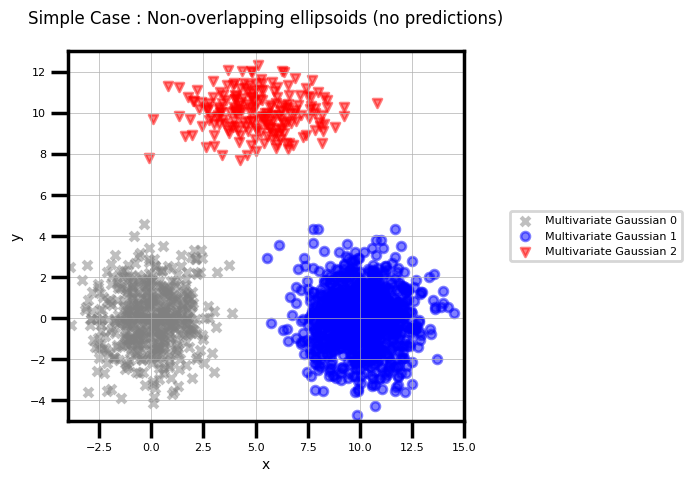

In [12]:
# plot the generated data
shapes = ['x', 'o', 'v']
colors = ['grey', 'blue', 'red']

fig, ax = plt.subplots(1, 1)

ax = plot_ellipsoids(data, shapes, colors, 
                     title = "Simple Case : Non-overlapping ellipsoids (no predictions)",
                     prediction = False, ax = ax)

plt.show()

##### 4.1.2 -- kMeans

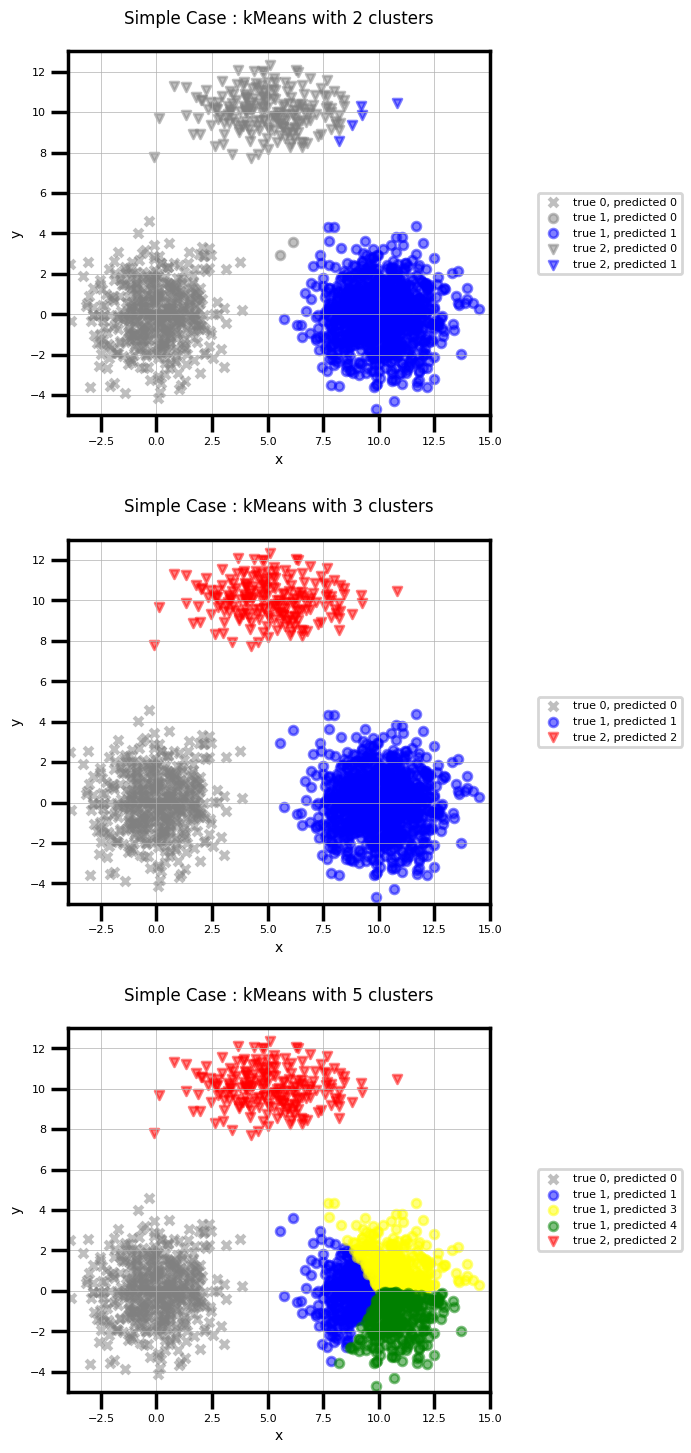

In [13]:
# let us now run the kMeans algorithm on the sampled data (basic case -- non-overlapping ellipsoids)
X = data[["x", "y"]]
k = [2, 3, 5]

shapes = ['x', 'o', 'v'] # real
colors = ['grey', 'blue', 'red', 'yellow', 'green', 'pink', 'orange'] # pred

fig, axs = plt.subplots(len(k), 1, figsize = (6, 14))
fig.tight_layout(h_pad = 8)

for i, ax in enumerate(axs.flat):
    kmeans = KMeans(n_clusters = k[i]).fit(X)
    preds = kmeans.labels_
    data["pred_label"] = reassign_preds(preds, data["true_label"], k[i])
    ax = plot_ellipsoids(data, shapes, colors,
                         title = f"Simple Case : kMeans with {k[i]} clusters",
                         prediction = True, ax = ax)

plt.show()

We can see that the kMeans solution models our data very well -- but only if we have chosen the correct number of classes in the beginning. To finetune the number of classes we want to use, we could utilize e.g. the elbow trick.

##### 4.1.3 -- GMM

GMM of complexity 2 converged after iteration 10
GMM of complexity 3 converged after iteration 9
GMM of complexity 5 breaked after reaching maximum iteration (100)


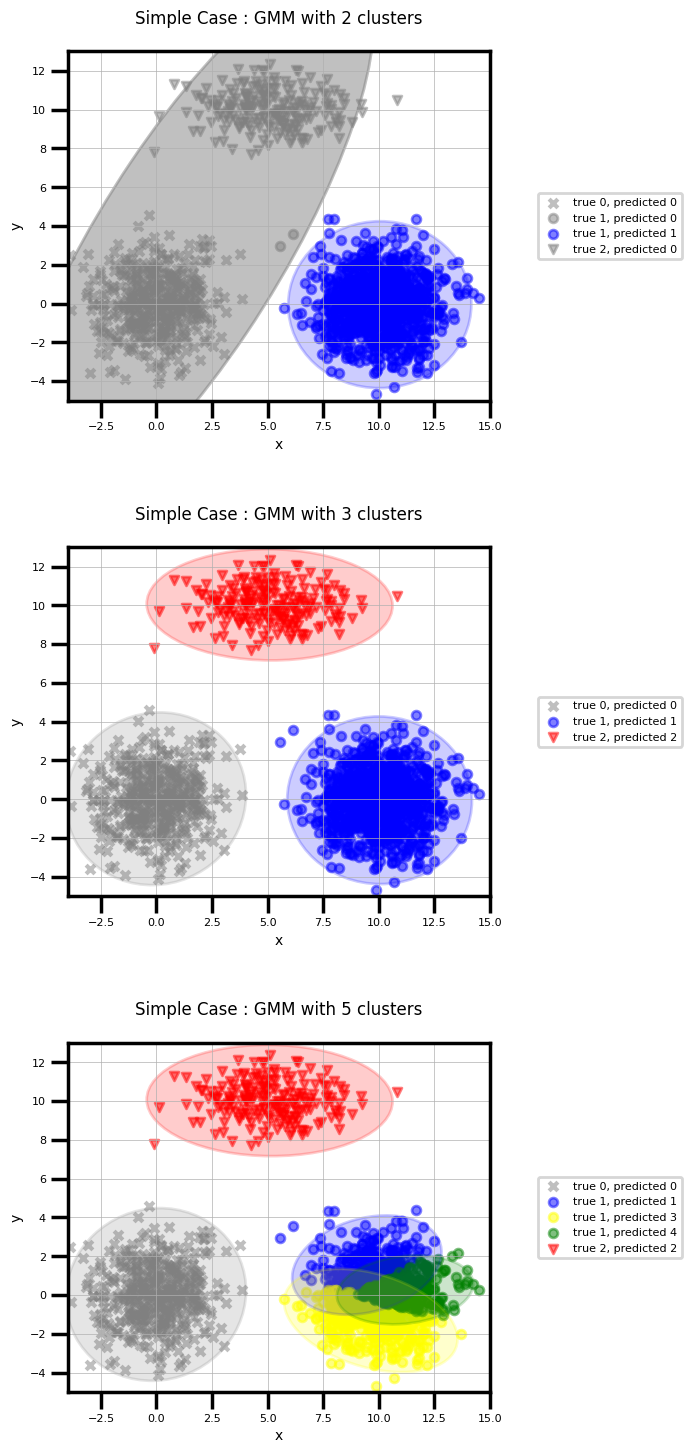

In [14]:
# let us now run our GMM on the sampled data (basic case -- non-overlapping ellipsoids)
X = data[["x", "y"]].to_numpy()
k = [2, 3, 5]

shapes = ['x', 'o', 'v'] # real
colors = ['grey', 'blue', 'red', 'yellow', 'green', 'pink', 'orange'] # pred

fig, axs = plt.subplots(len(k), 1, figsize = (6, 14))
fig.tight_layout(h_pad = 10)

for i, ax in enumerate(axs.flat):
    gmm = my_GMM(k[i])
    gmm.fit(X)
    preds = gmm.z_
    data["pred_label"] = reassign_preds(preds, data["true_label"], k[i])
    ax = plot_ellipsoids(data, shapes, colors,
                         title = f"Simple Case : GMM with {k[i]} clusters",
                         prediction = True, ax = ax,
                         plot_confidence_ellipsoids = True)

plt.show()

As we have initialized our GMM with the kMeans solution (see previous subsection), the results are basically equivalent. Again, we only get the correct result if we choose the correct number of classes (K = 3).

#### 4.2 Complex Case

Let us now sample datapoints from three overlapping ellipsoids. We should expect that k-Means performs (much) worse than GMM.

#####  4.2.1 -- Sample data

In [15]:
# define multivariate distributions from which we want to sample our data
means = [[5, 8],
         [4, 7],
         [6, 7]]
covs  = [[[5, 0], [0, 5]],
         [[.5, 0], [0, 18]],
         [[10, -7], [-7, 5.5]]]

sample_sizes = [1000, 1000, 2000]

data = sample_ellipsoids_pandas(3, 200, means, covs, sample_sizes)

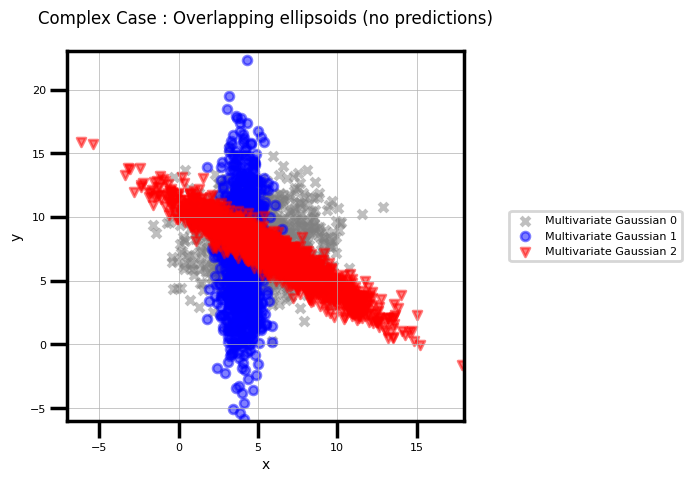

In [16]:
# plot the generated data
shapes = ['x', 'o', 'v']
colors = ['grey', 'blue', 'red']

fig, ax = plt.subplots(1, 1)

ax = plot_ellipsoids(data, shapes, colors, 
                     title = "Complex Case : Overlapping ellipsoids (no predictions)",
                     prediction = False, ax = ax,
                    )
plt.show()

##### 4.2.2 -- kMeans

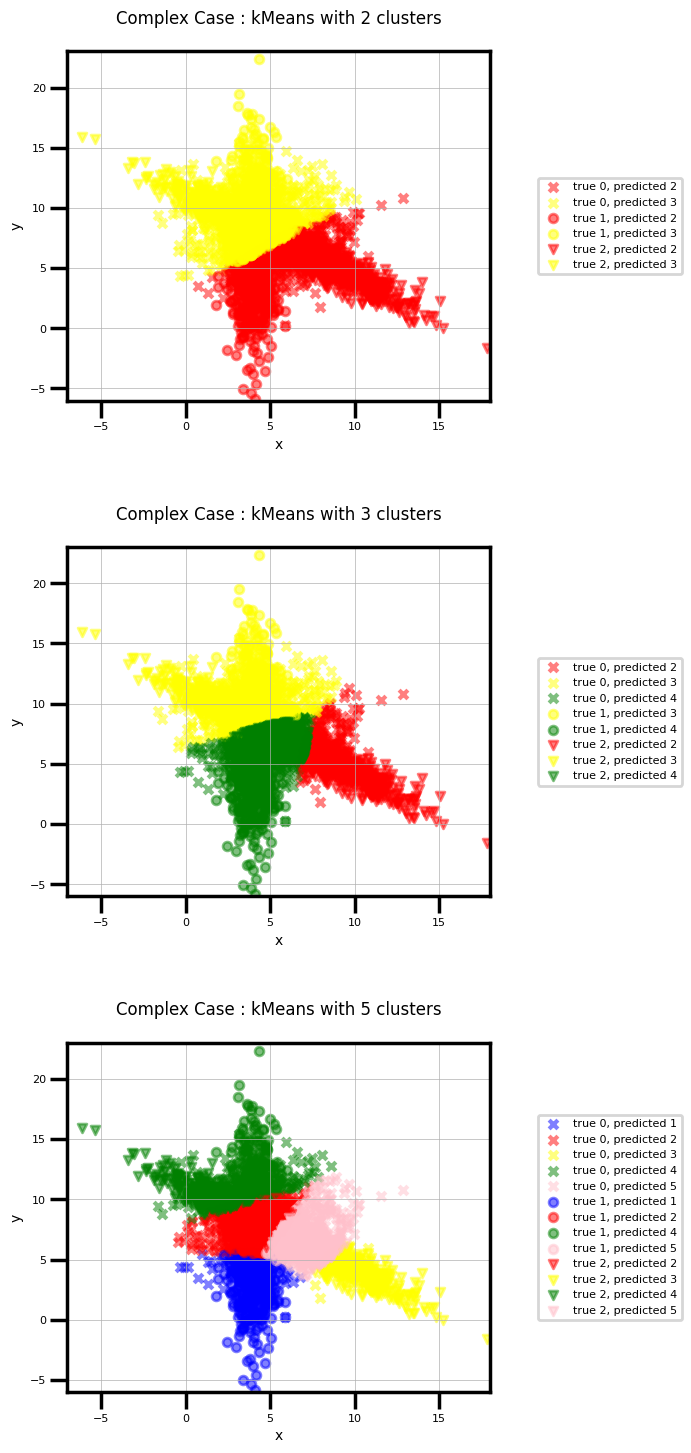

In [17]:
X = data[["x", "y"]]
k = [2, 3, 5]

shapes = ['x', 'o', 'v'] # real
colors = ['grey', 'blue', 'red', 'yellow', 'green', 'pink', 'orange'] # pred

fig, axs = plt.subplots(len(k), 1, figsize = (6, 14))
fig.tight_layout(h_pad = 10)

for i, ax in enumerate(axs.flat):
    kmeans = KMeans(n_clusters = k[i]).fit(X)
    preds = kmeans.labels_
    data["pred_label"] = reassign_preds(preds, data["true_label"], k[i])
    ax = plot_ellipsoids(data, shapes, colors,
                         title = f"Complex Case : kMeans with {k[i]} clusters",
                         prediction = True, ax = ax)

plt.show()

Just by looking at the graphs we can see that kMeans cannot distinguish between the overlapping distributions at all.

On top, we get even worse solutions if we have not set the number of components $K$ to the actually true number of components we have sampled from (in this case, we have sampled from 3 different Gaussian Multivariates).

##### 4.2.3 -- GMM

GMM of complexity 2 breaked after reaching maximum iteration (100)
GMM of complexity 3 converged after iteration 98
GMM of complexity 5 breaked after reaching maximum iteration (100)


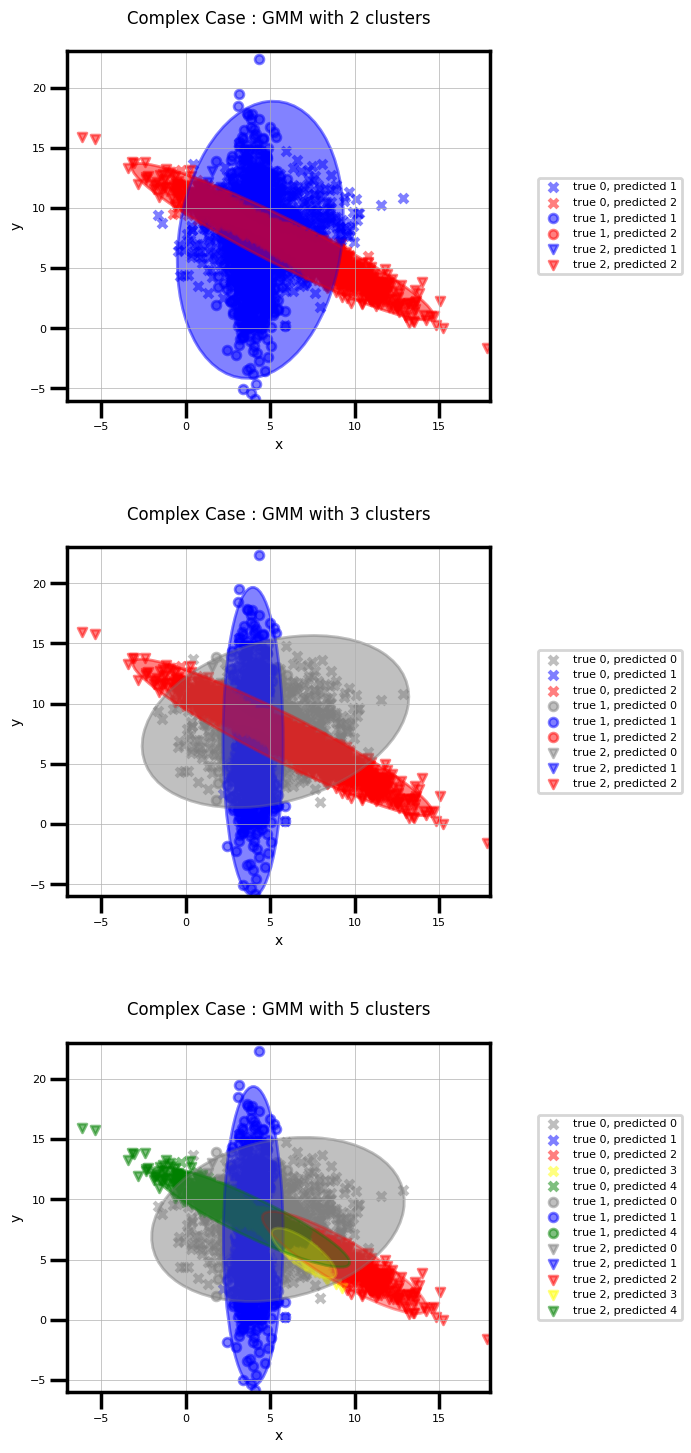

In [18]:
X = data[["x", "y"]].to_numpy()
k = [2, 3, 5]

shapes = ['x', 'o', 'v'] # real
colors = ['grey', 'blue', 'red', 'yellow', 'green', 'pink', 'orange'] # pred

fig, axs = plt.subplots(len(k), 1, figsize = (6, 14))
fig.tight_layout(h_pad = 10)

for i, ax in enumerate(axs.flat):
    gmm = my_GMM(k[i], m = 40)
    gmm.fit(X)
    preds = gmm.z_
    data["pred_label"] = reassign_preds(preds, data["true_label"], k[i])
    ax = plot_ellipsoids(data, shapes, colors,
                         title = f"Complex Case : GMM with {k[i]} clusters",
                         prediction = True, ax = ax,
                         plot_confidence_ellipsoids = True)

plt.show()

Just by looking at the graphs we can see that GMM can distinguish between the overlapping distributions very well (even though it was initialized with the very bad results of kMeans).

However, even GMM needs to be given the arbitrary number of components $K$ and, unless one deals with low-dimensional toy-datasets like the one I have sampled, it will be very hard to tell if GMM is "overfitting".

### 5. Evaluation (Complex Case only)

We will now evaluate the performance of GMM on our dataset fitted based on the true number of components $K = 3$.

GMM of complexity 3 converged after iteration 68


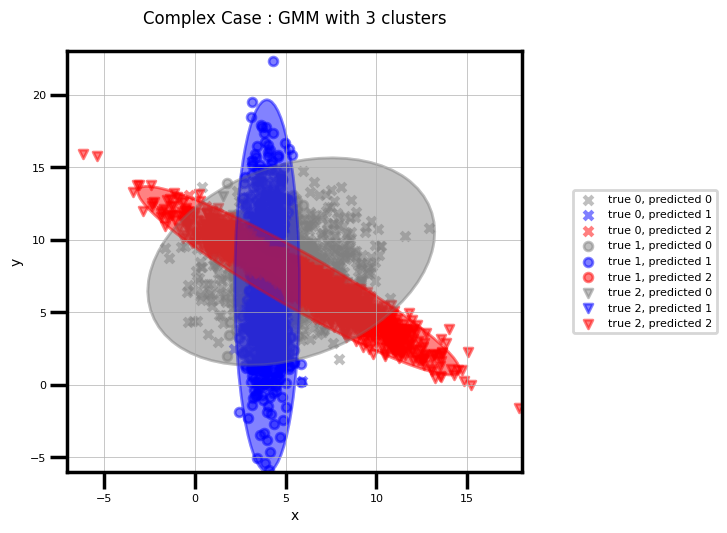

In [19]:
X = data[["x", "y"]].to_numpy()
k = 3

shapes = ['x', 'o', 'v'] # real
colors = ['grey', 'blue', 'red', 'yellow', 'green', 'pink', 'orange'] # pred

fig, axs = plt.subplots(1, 1)
fig.tight_layout(h_pad = 10)

gmm = my_GMM(k)
gmm.fit(X)
preds = gmm.z_
data["pred_label"] = reassign_preds(preds, data["true_label"], k)
axs = plot_ellipsoids(data, shapes, colors,
                     title = f"Complex Case : GMM with {k} clusters",
                     prediction = True, ax = axs,
                     plot_confidence_ellipsoids = True)

plt.show()

Agreement of labels in %: 0.75175


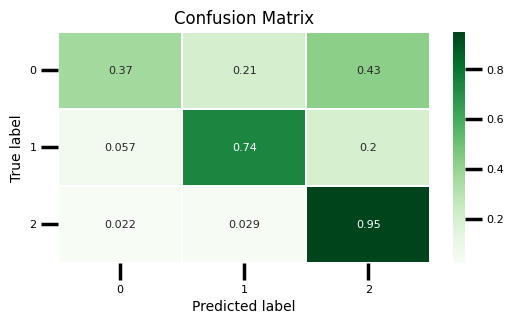

In [20]:
print("Agreement of labels in %:",np.mean(data["true_label"] == data["pred_label"]))

evaluate_preds(data["pred_label"], data["true_label"])

Even though we have sampled from three overlapping Gaussian Multivariates, the GMM with $k=3$ is able to correctly assign the labels of 75% of our observations (I was extremely surprised of the quality of the solution when I plotted it for the first time). Still our model had quite a lot of trouble to filter out correctly the component 0 (the circle behind the two ellipsoids), which is however understandable as we only have two points of information per datapoint.

### 6. Conclusion

As we have seen, GMM performs much better than kMeans on our sampled data. However, both algorithms share important limitations.

1. Both algorithms rely on the user to be given the arbitrary number of components 𝐾 that should be differentiated. Unless one deals with low-dimensional toy-datasets like the one I have sampled, it will be very hard to tell if the model is under- or overfitting.

2. The evaluation of unsupervised learning algorithms was not straightforward at all. E.g. I thought long about how to evaluate the perfomance of KMeans and GMM in a metric, and the only reasonable metric that came to my mind was the confusion matrix and the label agreement. This, however, only makes sense to compute if (1) you have chosen the correct number of $K$ components as otherwise you have predicted a different number of classes than true classes, and (2) if you can clearly assign the predicted components to the true components. E.g. in the complex case of GMM with 5 components, to which true label do I compare the predicted components 3 and 4 (in yellow and green)? I imagine if you do not have access to the true labels, the evaluation of the performance of one unsupervised learning algorithm against another is even harder and can only be done qualitatively (as in by looking at the predictions manually and trying to figure out which result you personally like more).

3. The components discovered within unsupervised learning algorithms do not necessarily line up with human intuition. In our simple toy example, it still worked as long as we chose the correct number of components. However, when we choose a too high number of components $K$, the algorithm did not stop to realize that the clustering at $K = 3$ makes perfect sense, but instead continued with 5 clusters to explain as much variance as possible. Thus, these unsupervised learning algorithms tend to find deep insights that do explain a lot of variance but also have very complicated definitions that can be hard to figure out.